## ThinkDSP

This notebook contains code examples from Chapter 8: Filtering and Convolution

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [2]:
from __future__ import print_function, division

%matplotlib inline

import thinkdsp
import thinkplot
import thinkstats2

import numpy as np
import pandas as pd
import scipy.signal

np.set_printoptions(precision=3, suppress=True)

In [3]:
PI2 = 2 * np.pi
GRAY = '0.7'

### Smoothing

As the first example, I'll look at daily closing stock prices for Facebook, from its IPO on 17 May 2012 to 8 December 2015 (note: the dataset includes only trading days )

In [4]:
names = ['date', 'open', 'high', 'low', 'close', 'volume']
df = pd.read_csv('fb.csv', header=0, names=names, parse_dates=[0])
df.head()

,date,open,high,low,close,volume
0,2015-12-08,104.00,106.91,103.95,106.49,20401791
1,2015-12-07,106.48,106.83,104.66,105.61,15474890
2,2015-12-04,104.75,107.73,104.11,106.18,21224721
3,2015-12-03,103.95,106.85,103.35,104.38,23236485
4,2015-12-02,107.00,107.92,105.79,106.07,24429063


Extract the close prices and days since start of series:

In [5]:
close = df.close.values[::-1]
dates = df.date.values[::-1]
days = (dates - dates[0]) / np.timedelta64(1,'D')

Make a window to compute a 30-day moving average and convolve the window with the data.  The `valid` flag means the convolution is only computed where the window completely overlaps with the signal.

In [6]:
M = 30
window = np.ones(M)
window /= sum(window)
smoothed = np.convolve(close, window, mode='valid')
smoothed_days = days[M//2: len(smoothed) + M//2]

Plot the original and smoothed signals.

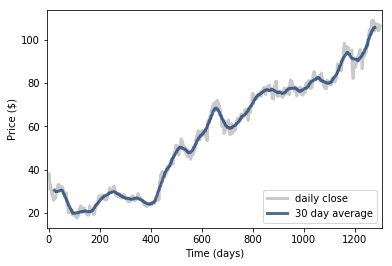

In [7]:
thinkplot.plot(days, close, color=GRAY, label='daily close')
thinkplot.plot(smoothed_days, smoothed, label='30 day average')

last = days[-1]
thinkplot.config(xlabel='Time (days)', 
                 ylabel='Price ($)',
                 xlim=[-7, last+7],
                 legend=True,
                 loc='lower right')

### Smoothing sound signals

Generate a 440 Hz sawtooth signal.

In [22]:
signal = thinkdsp.SawtoothSignal(freq=440)
wave = signal.make_wave(duration=1.0, framerate=44100)


wave.make_audio()

Make a moving average window.

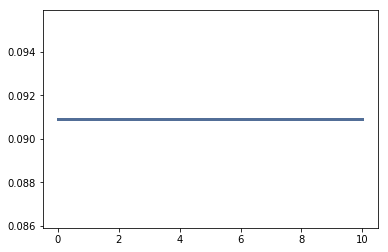

In [23]:
window = np.ones(11)
window /= sum(window)
thinkplot.plot(window)

Plot the wave.

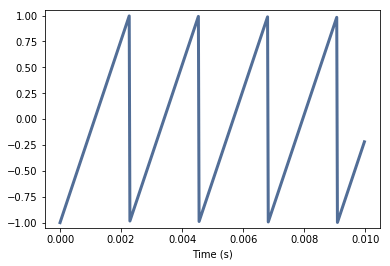

In [24]:
segment = wave.segment(duration=0.01)
segment.plot()
thinkplot.config(xlabel='Time (s)', ylim=[-1.05, 1.05])

Pad the window so it's the same length as the signal, and plot it.

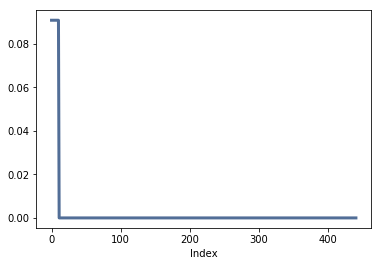

In [25]:
N = len(segment)
padded = thinkdsp.zero_pad(window, N)
thinkplot.plot(padded)
thinkplot.config(xlabel='Index')

Apply the window to the signal (with lag=0).

In [26]:
prod = padded * segment.ys
print(sum(prod))

-0.900181488203


Compute a convolution by rolling the window to the right.

In [27]:
smoothed = np.zeros(N)
rolled = padded.copy()
for i in range(N):
    smoothed[i] = sum(rolled * segment.ys)
    rolled = np.roll(rolled, 1)

Plot the result of the convolution and the original.

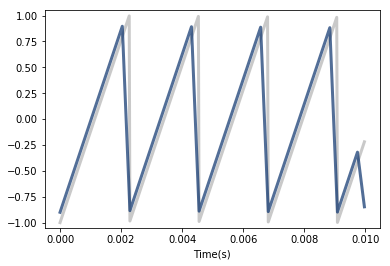

In [28]:
segment.plot(color=GRAY)
smooth = thinkdsp.Wave(smoothed, framerate=wave.framerate)
smooth.plot()
thinkplot.config(xlabel='Time(s)', ylim=[-1.05, 1.05])

Compute the same convolution using `numpy.convolve`.

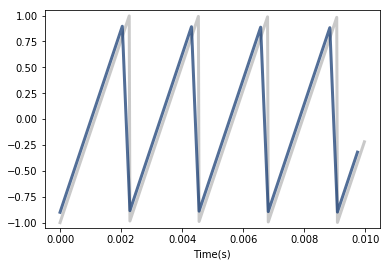

In [29]:
segment.plot(color=GRAY)
ys = np.convolve(segment.ys, window, mode='valid')
smooth2 = thinkdsp.Wave(ys, framerate=wave.framerate)
smooth2.plot()
thinkplot.config(xlabel='Time(s)', ylim=[-1.05, 1.05])

## Frequency domain

Let's see what's happening in the frequency domain.

Compute the smoothed wave using `np.convolve`, which is much faster than my version above.

In [30]:
convolved = np.convolve(wave.ys, window, mode='same')
smooth = thinkdsp.Wave(convolved, framerate=wave.framerate)
smooth.make_audio()

Plot spectrums of the original and smoothed waves:

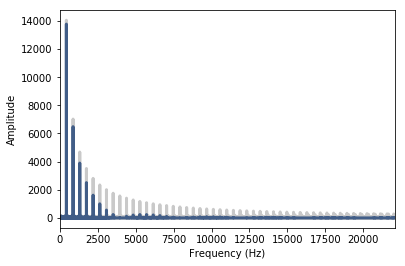

In [31]:
spectrum = wave.make_spectrum()
spectrum.plot(color=GRAY)

spectrum2 = smooth.make_spectrum()
spectrum2.plot()

thinkplot.config(xlabel='Frequency (Hz)',
                 ylabel='Amplitude',
                 xlim=[0, 22050])

For each harmonic, compute the ratio of the amplitudes before and after smoothing.

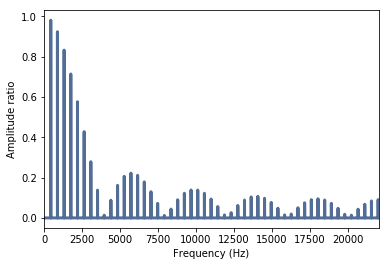

In [32]:
amps = spectrum.amps
amps2 = spectrum2.amps
ratio = amps2 / amps    
ratio[amps<280] = 0

thinkplot.plot(ratio)
thinkplot.config(xlabel='Frequency (Hz)',
                     ylabel='Amplitude ratio',
                     xlim=[0, 22050])

Plot the ratios again, but also plot the FFT of the window.

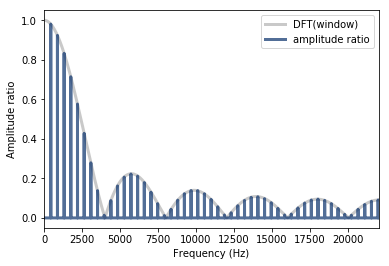

In [33]:
padded = thinkdsp.zero_pad(window, len(wave))
dft_window = np.fft.rfft(padded)

thinkplot.plot(abs(dft_window), color=GRAY, label='DFT(window)')
thinkplot.plot(ratio, label='amplitude ratio')

thinkplot.config(xlabel='Frequency (Hz)',
                     ylabel='Amplitude ratio',
                     xlim=[0, 22050], loc='upper right')

### Gaussian window

Let's compare boxcar and Gaussian windows.

Make the boxcar window.

In [34]:
boxcar = np.ones(11)
boxcar /= sum(boxcar)

Make the Gaussian window.

In [35]:
gaussian = scipy.signal.gaussian(M=11, std=2)
gaussian /= sum(gaussian)

Plot the two windows.

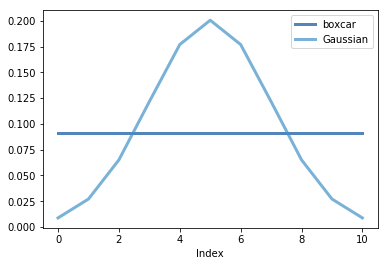

In [36]:
thinkplot.preplot(2)
thinkplot.plot(boxcar, label='boxcar')
thinkplot.plot(gaussian, label='Gaussian')
thinkplot.config(xlabel='Index',
                 loc='upper right')

Convolve the square wave with the Gaussian window.

In [37]:
ys = np.convolve(wave.ys, gaussian, mode='same')
smooth = thinkdsp.Wave(ys, framerate=wave.framerate)
spectrum2 = smooth.make_spectrum()

Compute the ratio of the amplitudes.

In [38]:
amps = spectrum.amps
amps2 = spectrum2.amps
ratio = amps2 / amps    
ratio[amps<560] = 0

Compute the FFT of the window.

In [39]:
padded = thinkdsp.zero_pad(gaussian, len(wave))
dft_gaussian = np.fft.rfft(padded)

Plot the ratios and the FFT of the window.

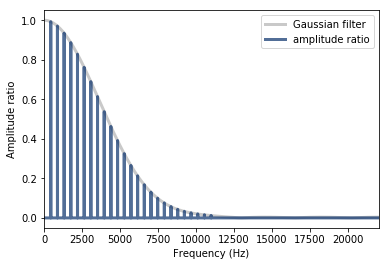

In [40]:
thinkplot.plot(abs(dft_gaussian), color='0.7', label='Gaussian filter')
thinkplot.plot(ratio, label='amplitude ratio')

thinkplot.config(xlabel='Frequency (Hz)',
                 ylabel='Amplitude ratio',
                 xlim=[0, 22050])

Combine the preceding example into one big function so we can interact with it.

In [41]:
def plot_filter(M=11, std=2):
    signal = thinkdsp.SquareSignal(freq=440)
    wave = signal.make_wave(duration=1, framerate=44100)
    spectrum = wave.make_spectrum()

    gaussian = scipy.signal.gaussian(M=M, std=std)
    gaussian /= sum(gaussian)
    high = gaussian.max()
    
    thinkplot.preplot(cols=2)
    thinkplot.plot(gaussian)
    thinkplot.config(xlabel='Index', ylabel='Window', 
                     xlim=[0, len(gaussian)-1], ylim=[0, 1.1*high])

    ys = np.convolve(wave.ys, gaussian, mode='same')
    smooth = thinkdsp.Wave(ys, framerate=wave.framerate)
    spectrum2 = smooth.make_spectrum()

    # plot the ratio of the original and smoothed spectrum
    amps = spectrum.amps
    amps2 = spectrum2.amps
    ratio = amps2 / amps    
    ratio[amps<560] = 0

    # plot the same ratio along with the FFT of the window
    padded = thinkdsp.zero_pad(gaussian, len(wave))
    dft_gaussian = np.fft.rfft(padded)

    thinkplot.subplot(2)
    thinkplot.plot(abs(dft_gaussian), color=GRAY, label='Gaussian filter')
    thinkplot.plot(ratio, label='amplitude ratio')

    thinkplot.show(xlabel='Frequency (Hz)',
                     ylabel='Amplitude ratio',
                     xlim=[0, 22050],
                     ylim=[0, 1.05])

Try out different values of `M` and `std`.

In [44]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

slider = widgets.IntSlider(min=2, max=100, value=11)
slider2 = widgets.FloatSlider(min=0, max=20, value=2)
interact(plot_filter, M=slider, std=slider2);

A Jupyter Widget

## Convolution theorem

Let's use the Convolution theorem to compute convolutions using FFT.  Read the Facebook data again, and smooth it using `np.convolve` and a 30-day Gaussian window.

I'll ignore the dates and treat the values as if they are equally spaced in time.

In [45]:
names = ['date', 'open', 'high', 'low', 'close', 'volume']
df = pd.read_csv('fb.csv', header=0, names=names, parse_dates=[0])
close = df.close.values[::-1]

window = scipy.signal.gaussian(M=30, std=6)
window /= window.sum()
smoothed = np.convolve(close, window, mode='valid')

len(close), len(smoothed)

(896, 867)

Plot the original and smoothed data.

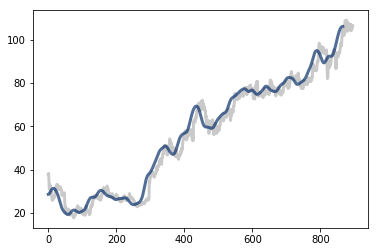

In [46]:
thinkplot.plot(close, color=GRAY)
thinkplot.plot(smoothed)

Pad the window and compute its FFT.

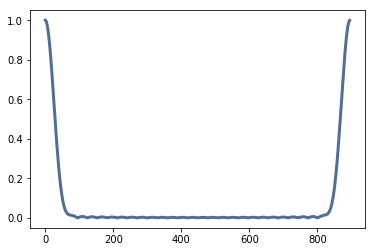

In [47]:
N = len(close)
padded = thinkdsp.zero_pad(window, N)
fft_window = np.fft.fft(padded)
thinkplot.plot(np.absolute(fft_window))

Apply the convolution theorem.

In [48]:
fft_signal = np.fft.fft(close)
smoothed2 = np.fft.ifft(fft_signal * fft_window)
M = len(window)
smoothed2 = smoothed2[M-1:]

Plot the two signals (smoothed with numpy and FFT).

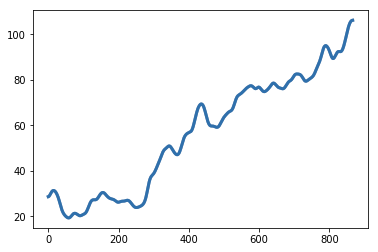

In [49]:
thinkplot.plot(smoothed)
thinkplot.plot(smoothed2.real)

Confirm that the difference is small.

In [50]:
diff = smoothed - smoothed2
max(abs(diff))

2.1705390082377723e-13

`scipy.signal` provides `fftconvolve`, which computes convolutions using FFT.

In [51]:
smoothed3 = scipy.signal.fftconvolve(close, window, mode='valid')

Confirm that it gives the same answer, at least approximately.

In [ ]:
diff = smoothed - smoothed3
max(abs(diff))

We can encapsulate the process in a function:

In [ ]:
def fft_convolve(signal, window):
    fft_signal = np.fft.fft(signal)
    fft_window = np.fft.fft(window)
    return np.fft.ifft(fft_signal * fft_window)

And confirm that it gives the same answer.

In [ ]:
smoothed4 = fft_convolve(close, padded)[M-1:]
len(smoothed4)

In [ ]:
diff = smoothed - smoothed4
max(abs(diff))

### Autocorrelation

We can also use the convolution theorem to compute autocorrelation functions.

Compute autocorrelation using `numpy.correlate`:


In [ ]:
corrs = np.correlate(close, close, mode='same')
corrs[:7]

Compute autocorrelation using my `fft_convolve`.  The window is a reversed copy of the signal.  We have to pad the window and signal with zeros and then select the middle half from the result.

In [ ]:
def fft_autocorr(signal):
    N = len(signal)
    signal = thinkdsp.zero_pad(signal, 2*N)
    window = np.flipud(signal)

    corrs = fft_convolve(signal, window)
    corrs = np.roll(corrs, N//2+1)[:N]
    return corrs

Test the function.

In [ ]:
corrs2 = fft_autocorr(close)
corrs2[:7]

Plot the results.

In [ ]:
lags = np.arange(N) - N//2
thinkplot.plot(lags, corrs, color=GRAY, linewidth=7, label='np.convolve')
thinkplot.plot(lags, corrs2.real, linewidth=2, label='fft_convolve')
thinkplot.config(xlabel='Lag', ylabel='Correlation')
len(corrs), len(corrs2)

Confirm that the difference is small.

In [ ]:
diff = corrs - corrs2.real
max(abs(diff))